# Importing library

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## Load Data

In [38]:
company = "GOOG" #Google company

In [47]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2021, 1, 1)

In [48]:
data = web.get_data_stooq(company, start=start, end=end)

## Prepare Data

In [49]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Bulid The Model

In [44]:
model = Sequential()

In [45]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [46]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [50]:
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
52/52 [==============================] - 8s 20ms/step - loss: 0.0089
Epoch 2/25
52/52 [==============================] - 1s 15ms/step - loss: 0.0032
Epoch 3/25
52/52 [==============================] - 1s 15ms/step - loss: 0.0027
Epoch 4/25
52/52 [==============================] - 1s 15ms/step - loss: 0.0026
Epoch 5/25
52/52 [==============================] - 1s 15ms/step - loss: 0.0026
Epoch 6/25
52/52 [==============================] - 1s 15ms/step - loss: 0.0024
Epoch 7/25
52/52 [==============================] - 1s 15ms/step - loss: 0.0019
Epoch 8/25
52/52 [==============================] - 1s 14ms/step - loss: 0.0018
Epoch 9/25
52/52 [==============================] - 1s 14ms/step - loss: 0.0021
Epoch 10/25
52/52 [==============================] - 1s 14ms/step - loss: 0.0017
Epoch 11/25
52/52 [==============================] - 1s 15ms/step - loss: 0.0018
Epoch 12/25
52/52 [==============================] - 1s 15ms/step - loss: 0.0016
Epoch 13/25
52/52 [==================

## Load Test Data

In [54]:
test_start = dt.datetime(2021, 1, 1)
test_end = dt.datetime.now()

test_data = web.get_data_stooq(company, start=test_start, end=test_end)

In [55]:
actual_prices = test_data["Close"].values
actual_prices

array([116.87  , 120.14  , 120.93  , 122.63  , 120.56  , 120.97  ,
       120.01  , 121.08  , 119.01  , 119.09  , 123.02  , 123.87  ,
       121.26  , 123.85  , 124.06  , 125.79  , 124.38  , 124.43  ,
       124.35  , 122.87  , 122.67  , 122.94  , 127.91  , 126.63  ,
       125.23  , 124.37  , 123.37  , 124.64  , 125.43  , 124.35  ,
       121.64  , 123.29  , 125.87  , 123.25  , 123.52  , 121.48  ,
       120.09  , 116.96  , 117.92  , 116.9   , 112.28  , 107.94  ,
       108.24  , 106.215 , 105.21  , 106.12  , 105.98  , 107.71  ,
       108.22  , 108.37  , 104.45  , 104.61  , 106.78  , 105.91  ,
       105.9   , 105.02  , 105.12  , 106.42  , 109.46  , 108.19  ,
       105.22  , 106.12  , 106.95  , 108.9   , 104.95  , 105.12  ,
       104.91  , 104.    , 101.32  , 101.9   , 101.36  , 103.06  ,
       106.06  , 106.26  , 104.22  , 105.84  , 101.93  , 102.46  ,
       101.07  ,  96.55  ,  94.25  ,  91.66  ,  91.01  ,  92.66  ,
        94.65  ,  94.17  ,  95.58  ,  94.02  ,  92.31  ,  90.5

In [56]:
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

In [58]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

In [59]:
reshaped_model_inputs = model_inputs.reshape(-1, 1)

In [60]:
scaled_model_inputs = scaler.transform(reshaped_model_inputs)

In [62]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(scaled_model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [63]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

20/20 [==============================] - 1s 25ms/step


## Plot The Test Predictions

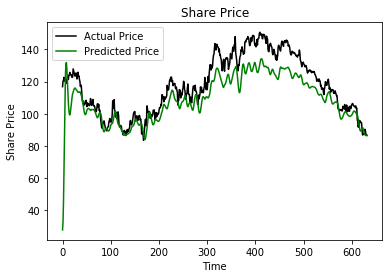

In [64]:
plt.plot(actual_prices, color="black", label=f"Actual Price")
plt.plot(predicted_prices, color="green", label=f"Predicted Price")
plt.title('Share Price')
plt.xlabel('Time')
plt.ylabel('Share Price')
plt.legend()
plt.show()

## Predict Next Day

In [68]:
real_data = [scaled_model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

print(f"The Prediction is {prediction[0][0]}")

1/1 [==============================] - 0s 21ms/step
The Prediction is 86.54878997802734


## Save the Model

In [65]:
model.save("models/google_model.h5")

## Load the model

In [ ]:
from tensorflow.keras.models import load_model
model_dir = ""
new_model = load_model(model_dir)